# Video Conversion & Analysis

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

This notebook converts videos into a data structure for use in other notebooks. Given a folder of videos, store the coordinates of each video frame in a data structure for later analysis (see output). Further, some data analysis of the videos are done.

INPUT: video folder

OUTPUT: list of tuples with the form - (label, [ {'frames': frame_number (int), 'coordinates': {x1, y1.,..(all the keypoints)} }])

## TOC:
0. [Setup](#0.-Import-Libraries-&-Setup)
1. [Capture & Store Frames in DS](#1.-Capture-&-Store-Frames)
2. [Save & Load DS From Local Storage](#2.-Save-&-Load-Frames)
3. [Visualise Data](#3.-Visualise-Data)

# 0. Import Libraries & Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cv2
import mediapipe as mp

import math

import os

from sklearn.model_selection import train_test_split

import pickle

# 1. Capture & Store Frames

In [2]:
all_landmarks = [] # List of dictionaries storing all the landmarks for every frame of one video

def label_landmarks(frame_number, landmarks):
    unboxed_landmarks = {}

    for i in range(33):
        unboxed_landmarks['x' + str(i)] = landmarks.landmark[i].x
        unboxed_landmarks['y' + str(i)] = landmarks.landmark[i].y
        unboxed_landmarks['z' + str(i)] = landmarks.landmark[i].z
        
    all_landmarks.append({ 'frame': frame_number, 'coordinates': unboxed_landmarks })

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

all_videos = [] # List of tuples - get the label from the file

directory = os.fsencode('bicep-curl-videos') # Folder of videos

exit = False

for file in os.listdir(directory):
    frame_count = 1
    filename = os.fsdecode(file)
    cap = cv2.VideoCapture('bicep-curl-videos/' + filename)
    with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:

        while cap.isOpened():
            ret, image = cap.read()

            if ret == False:
                break
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            k = cv2.waitKey(1)
            if results.pose_landmarks != None:
                label_landmarks(frame_count, results.pose_landmarks) # store the landmarks frame by frame
                frame_count += 1
                
            if cv2.waitKey(10) & 0xFF == ord('q'):
                exit = True
                break

            cv2.imshow("output", image)

        cap.release()
        cv2.destroyAllWindows()
        
        name = None
        
        if 'good' in filename:
            name = 'good'
        elif 'shoulder' in filename:
            name = 'shoulder'
        elif 'elbow' in filename:
            name = 'elbow'
        
        # Save the list of frames to coordinates in all_videos and then go onto next video
        tup = (name, all_landmarks.copy())
        all_videos.append(tup)
        all_landmarks.clear()
        if exit == True:
            break

# 2. Save & Load Frames

In [21]:
pickle.dump(all_videos, open('all-bicep-curls.dump', 'wb'))

In [26]:
all_videos = pickle.load(open('all-bicep-curls.dump', 'rb'))
print(len(all_videos))

85


# 3. Visualise Data

In [27]:
# The list we want to convert has format: [{'frame': num, 'coordinates': {'x1'...'z33'}}]
# INPUT: list of the frames to coordinates for one video
# OUTPUT: DataFrame of the list
def convert_list_to_df(list_to_convert):
    d = {'frame': []}
    for i in range(33):
        d['x' +  str(i)] = []
        d['y' +  str(i)] = []
        d['z' +  str(i)] = []
    
    for frame in list_to_convert:
        d['frame'].append(frame['frame'])
        for j in range(33):
            d['x' +  str(j)].append(frame['coordinates']['x' + str(j)])
            d['y' +  str(j)].append(frame['coordinates']['y' + str(j)])
            d['z' +  str(j)].append(frame['coordinates']['z' + str(j)])
    return d

Lets set aside the videos for training and testing so we can spot trends in just the training set. The same seed (random_state value) is used in f1-gen-heuristic notebook so the corresponding testing set is created.

In [28]:
all_videos, _, _, _ = train_test_split(all_videos, all_videos, test_size=0.33, random_state=42)
print(len(all_videos))

56


Now, lets take 3 examples from the training dataset. A good example, an example that uses shoulder in the movemenet and an example where the elbow is not tucked in to the sides during the movement.

We put the list of frames to coordinates in a DataFrame for analysis.

In [29]:
# Display what video is at each index
for i in range(len(all_videos)):
    print(str(i) + '. ' +  all_videos[i][0])

0. elbow
1. elbow
2. shoulder
3. good
4. shoulder
5. good
6. shoulder
7. elbow
8. good
9. shoulder
10. good
11. elbow
12. good
13. shoulder
14. good
15. good
16. elbow
17. good
18. shoulder
19. good
20. elbow
21. shoulder
22. shoulder
23. elbow
24. elbow
25. shoulder
26. good
27. good
28. elbow
29. elbow
30. good
31. elbow
32. good
33. elbow
34. shoulder
35. shoulder
36. elbow
37. elbow
38. shoulder
39. elbow
40. shoulder
41. shoulder
42. elbow
43. good
44. good
45. elbow
46. good
47. good
48. good
49. shoulder
50. shoulder
51. good
52. elbow
53. shoulder
54. good
55. elbow


In [30]:
df_elbow = pd.DataFrame(convert_list_to_df(all_videos[11][1]))
all_videos[11][0]

'elbow'

In [31]:
df_good = pd.DataFrame(convert_list_to_df(all_videos[5][1]))
all_videos[5][0]

'good'

In [32]:
df_shoulder = pd.DataFrame(convert_list_to_df(all_videos[53][1]))
all_videos[53][0]

'shoulder'

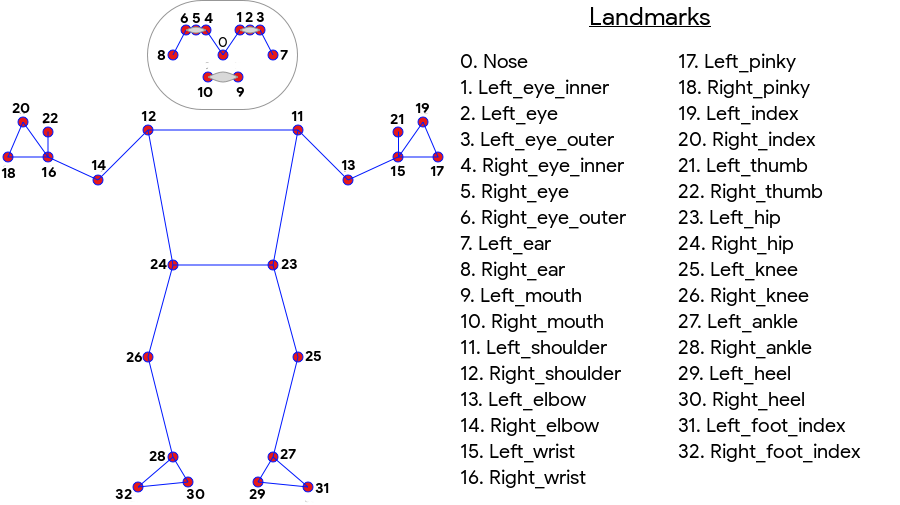

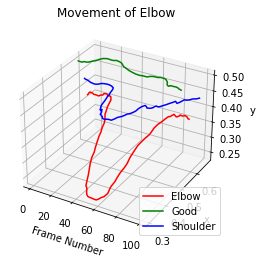

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(df_elbow.frame, df_elbow.x13, df_elbow.y13, 'red')
ax.plot3D(df_good.frame, df_good.x13, df_good.y13, 'green')
ax.plot3D(df_shoulder.frame, df_shoulder.x13, df_shoulder.y13, 'blue')
ax.legend(['Elbow', 'Good', 'Shoulder'])
ax.set_title('Movement of Elbow')
ax.set_xlabel('Frame Number')
ax.set_ylabel('x')
ax.set_zlabel('y')
plt.show()

Figure shows the movement of the elbow coordinate in each frame. The graph shows the elbow keypoint moves a lot when the elbows aren't placed to the side in the exercise. In a good performance of the exercise, the elbow moves the least.

In [34]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [35]:
df_elbow['angle'] = df_elbow.apply(lambda row: get_angle(row, 23, 11, 13), axis=1)
df_elbow[['frame', 'angle']]

,frame,angle
0,1,6.135704
1,2,5.562608
2,3,4.947041
3,4,4.326722
4,5,4.080118
...,...,...
94,95,3.739888
95,96,3.428626
96,97,3.030469
97,98,1.992068


In [36]:
# Plot a 2D graph to show how the angle between 3 keypoints changes in each frame, using the 4 example videos
# INPUT: the 3 keypoints of the angle we want to track (3 ints) and the title of the graph (str)
# OUTPUT: 2D graph
def gen_2d_graph(keypoint_1, keypoint_2, keypoint_3, title):
    df_elbow['angle'] = df_elbow.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    ax = df_elbow.plot(kind='scatter', x='frame', y='angle', color='red')

    df_good['angle'] = df_good.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    df_good.plot(ax=ax, kind='scatter', x='frame', y='angle', color='green')

    df_shoulder['angle'] = df_shoulder.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    df_shoulder.plot(ax=ax, kind='scatter', x='frame', y='angle', color='blue')

    ax.set_title(title)
    ax.legend(['Elbow', 'Good', 'Shoulder'])

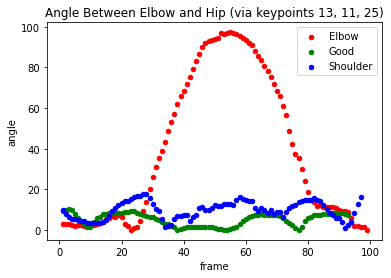

In [37]:
gen_2d_graph(13, 11, 25, 'Angle Between Elbow and Hip (via keypoints 13, 11, 25)')

The graph above shows the angle is a lot higher when the elbows are not tucked in.

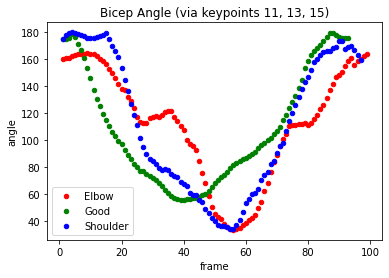

In [38]:
gen_2d_graph(11, 13, 15, 'Bicep Angle (via keypoints 11, 13, 15)')

Hard to tell much from this graph.

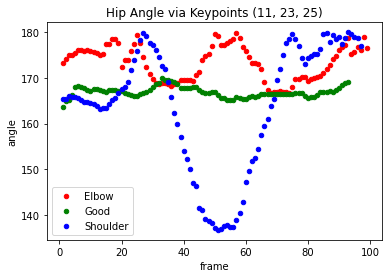

In [39]:
gen_2d_graph(11, 23, 25, 'Hip Angle via Keypoints (11, 23, 25)')

When the shoulder is used for momentum in the angle dips below 160 degree.

The pattern seems clear from the 3 examples taken from the dataset, lets use all the videos in the training set to see if the pattern is still the same.

In [40]:
elbow_dfs = []
shoulder_dfs = []
good_dfs = []

for vid in all_videos:
    if vid[0] == 'elbow':
        elbow_dfs.append(pd.DataFrame(convert_list_to_df(vid[1])))
    elif vid[0] == 'shoulder':
        shoulder_dfs.append(pd.DataFrame(convert_list_to_df(vid[1])))
    else:
        good_dfs.append(pd.DataFrame(convert_list_to_df(vid[1])))

In [41]:
df_elbow_concat = pd.concat(elbow_dfs)
df_shoulder_concat = pd.concat(shoulder_dfs)
df_good_concat = pd.concat(good_dfs)

df_elbow_means = (df_elbow_concat.groupby(df_elbow_concat.frame)).mean()
df_shoulder_means = (df_shoulder_concat.groupby(df_shoulder_concat.frame)).mean()
df_good_means = (df_good_concat.groupby(df_good_concat.frame)).mean()

In [42]:
df_good_means

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,z29,x30,y30,z30,x31,y31,z31,x32,y32,z32
frame,,,,,,,,,,,,,,,,,,,,,
1,0.412434,0.208254,-0.337756,0.424413,0.188478,-0.389422,0.430662,0.187510,-0.389496,0.437532,...,0.231026,0.598470,0.879039,0.822542,0.454115,0.952399,0.039440,0.453865,0.885673,0.746054
2,0.412489,0.208901,-0.339178,0.424819,0.189444,-0.391646,0.431048,0.188533,-0.391667,0.437887,...,0.193546,0.598568,0.878326,0.858995,0.451749,0.952715,0.000661,0.450681,0.885164,0.798540
3,0.412541,0.209486,-0.343617,0.425222,0.190155,-0.396717,0.431437,0.189275,-0.396732,0.438278,...,0.197632,0.597461,0.878064,0.872617,0.449317,0.951229,0.006574,0.448884,0.884402,0.819142
4,0.412702,0.209692,-0.342149,0.425722,0.190473,-0.395697,0.431874,0.189616,-0.395710,0.438624,...,0.193166,0.596819,0.878169,0.881158,0.448455,0.950734,0.001266,0.447461,0.883862,0.828263
5,0.413045,0.209749,-0.345958,0.426282,0.190636,-0.399166,0.432416,0.189792,-0.399168,0.439100,...,0.193630,0.596675,0.878420,0.883837,0.447598,0.950245,0.000734,0.447294,0.883429,0.830728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.391628,0.151541,-0.303887,0.406536,0.130189,-0.364708,0.412808,0.129670,-0.364887,0.419416,...,0.246460,0.574798,0.874312,0.841450,0.422367,0.920407,0.063185,0.430280,0.864658,0.775521
124,0.376977,0.185479,-0.280137,0.390624,0.164617,-0.334985,0.396735,0.163970,-0.335081,0.403136,...,0.167200,0.562222,0.847363,0.919925,0.420747,0.924798,-0.008993,0.429246,0.844101,0.901361
125,0.376128,0.185494,-0.265138,0.389665,0.164672,-0.318496,0.395930,0.164028,-0.318602,0.402451,...,0.128850,0.561345,0.848012,0.924736,0.419525,0.924085,-0.049979,0.429538,0.843734,0.909180


The DataFrame represents all the mean values of the coordinates in each frame of every video in the training dataset.

In [43]:
# Plot a 2D graph to show how the angle between 3 keypoints changes in each frame, using the 4 example mistakes mean dfs
# INPUT: the 3 keypoints of the angle we want to track (3 ints), name of the angle (str) and the title of the graph (str)
# OUTPUT: 2D graph
def gen_2d_means_graph(keypoint_1, keypoint_2, keypoint_3, angle_name, title):
    df_elbow_means[angle_name] = df_elbow_means.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    ax = df_elbow_means.reset_index().plot(kind='scatter', x='frame', y=angle_name, color='red')

    df_good_means[angle_name] = df_good_means.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    df_good_means.reset_index().plot(ax=ax, kind='scatter', x='frame', y=angle_name, color='green')

    df_shoulder_means[angle_name] = df_shoulder_means.apply(lambda row: get_angle(row, keypoint_1, keypoint_2, keypoint_3), axis=1)
    df_shoulder_means.reset_index().plot(ax=ax, kind='scatter', x='frame', y=angle_name, color='blue')
    
    ax.set_title(title)
    ax.legend(['Elbow', 'Good', 'Shoulder'])

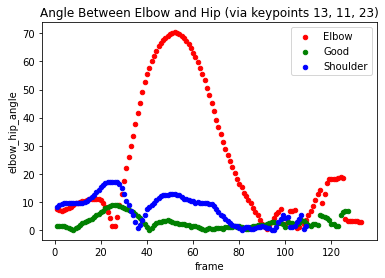

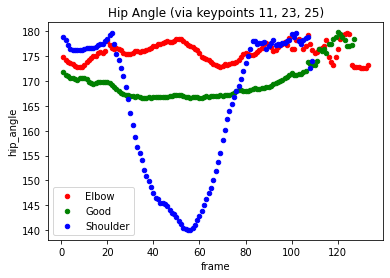

In [44]:
gen_2d_means_graph(13, 11, 23, 'elbow_hip_angle', 'Angle Between Elbow and Hip (via keypoints 13, 11, 23)')
# plt.savefig('bc-elbow-hip-means.svg', bbox_inches='tight')
gen_2d_means_graph(11, 23, 25, 'hip_angle', 'Hip Angle (via keypoints 11, 23, 25)')
# plt.savefig('bc-hip-means.svg', bbox_inches='tight')

The pattern still remains the same as before.

    1. In a video where the elbows are not tucked in, the angle between the elbow and hip will be greater than 30 degrees.
    2. In a video where the shoulder is used for momentum, the hip angle will dip below 165 degrees.